
Notebook: Entrenamiento y comparación de modelos clásicos (HSV+HOG reducido, features curadas)


In [4]:
import os, time, json
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix
)

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import pyfiglet
import seaborn as sns
import matplotlib.pyplot as plt

# Configuracion de ruta de datos y parametros para el procesamiento y creacion de modelos
DATA_ROOT   = r"C:\Users\GMADRO04\Documents\PALAS_EOLICAS_ML\processed_data\data_bin"
# pca para reducir dimensionalidad
USE_PCA     = True     # pon False si quieres ver sin PCA
N_PCA       = 200      # 150-300 se puesde ajustar en ese rango para buena precision o resultados
# si no se usa PCA, se usa la normalizacion estandar
RANDOM_STATE= 42
CV_SPLITS   = 3
N_JOBS      = -1       # usa todos los cores
# Configuracion de pandas y numpy para mejor visualizacion
np.set_printoptions(suppress=True)
pd.set_option("display.max_colwidth", 120)


In [6]:
# Cargar los datos de entrenamiento, validacion y prueba
def load_split(name):
    df = pd.read_csv(os.path.join(DATA_ROOT, f"features_{name}_curado.csv"))
    cols = [c for c in df.columns if c not in ["file","split","label"]]
    X = df[cols].values.astype(np.float32)
    y = df["label"].astype(int).values  # 0=dañada, 1=sana
    files = df["file"].tolist()
    return X, y, files, cols, df

Xtr, ytr, ftr, cols, df_tr = load_split("train")
Xva, yva, fva, _,   df_va = load_split("val")
Xte, yte, fte, _,   df_te = load_split("test")

Xtrva = np.vstack([Xtr, Xva])
ytrva = np.concatenate([ytr, yva])

print(pyfiglet.figlet_format("Datos para entrenamiento de modelos", font="digital"))
print(" Datos para entrenamiento", Xtr.shape, " val:", Xva.shape, " test:", Xte.shape)
print(" Total de caracteristicas:", len(cols))
print(" Clases (0=dañada, 1=sana) -> train:", np.bincount(ytr), "val:", np.bincount(yva), "test:", np.bincount(yte))


+-+-+-+-+-+ +-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+
|D|a|t|o|s| |p|a|r|a| |e|n|t|r|e|n|a|m|i|e|n|t|o| |d|e| |m|o|d|e|l|o|s|
+-+-+-+-+-+ +-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+

 Datos para entrenamiento (1300, 4504)  val: (94, 4504)  test: (94, 4504)
 Total de caracteristicas: 4504
 Clases (0=dañada, 1=sana) -> train: [650 650] val: [44 50] test: [44 50]


In [12]:
"""PARAMETROS DE MODELOS SVM, MLP, RF, KNN, LR"""

def base_steps():
    steps = [("scaler", StandardScaler())]
    if USE_PCA:
        steps.append(("pca", PCA(n_components=N_PCA, svd_solver="randomized", random_state=RANDOM_STATE)))
    return steps

models = {
    "SVM_RBF": {
        "estimator": Pipeline(base_steps() + [("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))]),
        "param_grid": {
            "clf__C": [0.05, 0.1, 0.5, 1.0, 3.0],
            "clf__gamma": ["scale", 0.01, 0.001, 0.0001],
        }
    },
    "LogReg": {
        "estimator": Pipeline(base_steps() + [("clf", LogisticRegression(max_iter=3000, n_jobs=N_JOBS, random_state=RANDOM_STATE))]),
        "param_grid": {
            "clf__C": [0.05, 0.5, 1.0, 3.0],
            "clf__penalty": ["l2"],
        }
    },
    "RF": {
        "estimator": Pipeline(base_steps() + [("clf", RandomForestClassifier(random_state=RANDOM_STATE))]),
        "param_grid": {
            "clf__n_estimators": [200],
            "clf__max_depth": [None, 20],
            "clf__max_features": ["sqrt"],
        }
    },
    "kNN": {
        "estimator": Pipeline(base_steps() + [("clf", KNeighborsClassifier())]),
        "param_grid": {
            "clf__n_neighbors": [3,5,7],
            "clf__weights": ["uniform", "distance"],
        }
    },
    "MLP": {
        "estimator": Pipeline(base_steps() + [("clf", MLPClassifier(max_iter=300, early_stopping=True, random_state=RANDOM_STATE))]),
        "param_grid": {
            "clf__hidden_layer_sizes": [(128,), (256,)],
            "clf__alpha": [1e-4, 1e-3],
        }
    },
}


In [13]:
# Funciones para entrenar y evaluar modelos con las metricas
def compute_metrics(y_true, y_pred, y_prob=None, pos_label=1):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0, pos_label=pos_label
    )
    roc = np.nan
    if y_prob is not None:
        try:
            roc = roc_auc_score(y_true, y_prob)
        except Exception:
            pass
    cm = confusion_matrix(y_true, y_pred)
    return acc, prec, rec, f1, roc, cm

def predict_proba_safe(clf, X):
    try:
        return clf.predict_proba(X)[:,1]
    except Exception:
        try:
            d = clf.decision_function(X)
            dmin, dmax = d.min(), d.max()
            return (d - dmin) / (dmax - dmin) if dmax > dmin else None
        except Exception:
            return None

def show_confusion(cm, title="Matriz de confusión", labels=("Dañada (0)","Sana (1)")):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout()
    plt.show()



Entrenando SVM_RBF (CV=3)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores params: {'clf__C': 3.0, 'clf__gamma': 'scale'}
[VAL] acc=0.862 f1=0.869 prec=0.878 rec=0.860 auc=0.909


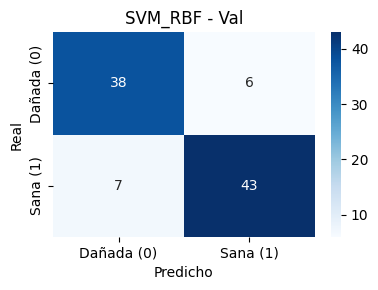

[TEST] acc=0.894 f1=0.896 prec=0.935 rec=0.860 auc=0.943


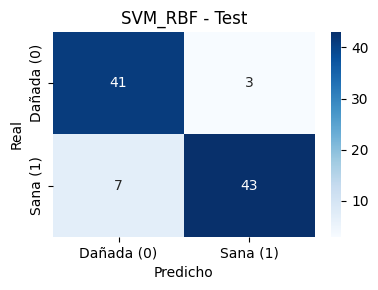


Entrenando LogReg (CV=3)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores params: {'clf__C': 0.05, 'clf__penalty': 'l2'}
[VAL] acc=0.777 f1=0.792 prec=0.784 rec=0.800 auc=0.834


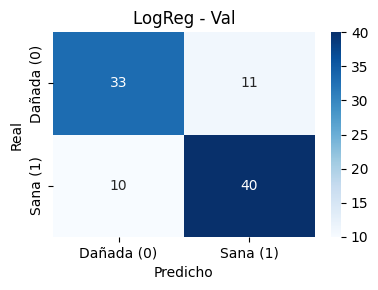

[TEST] acc=0.851 f1=0.863 prec=0.846 rec=0.880 auc=0.898


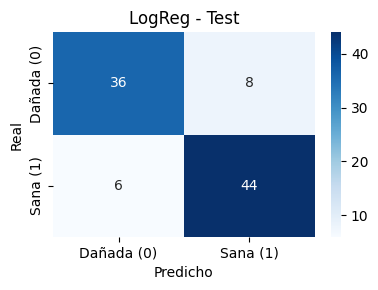


Entrenando RF (CV=3)
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Mejores params: {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}
[VAL] acc=0.787 f1=0.792 prec=0.826 rec=0.760 auc=0.873


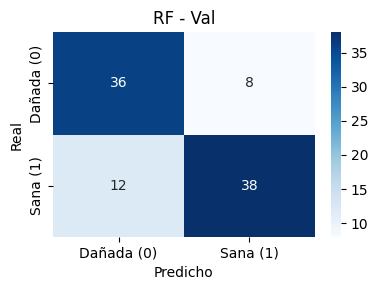

[TEST] acc=0.904 f1=0.909 prec=0.918 rec=0.900 auc=0.935


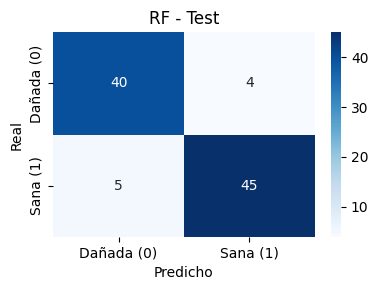


Entrenando kNN (CV=3)
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Mejores params: {'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
[VAL] acc=0.819 f1=0.828 prec=0.837 rec=0.820 auc=0.879


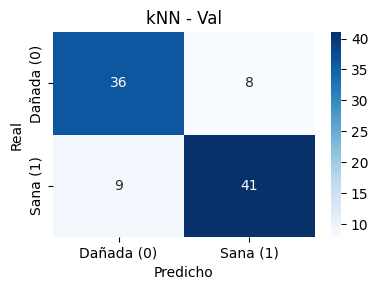

[TEST] acc=0.830 f1=0.837 prec=0.854 rec=0.820 auc=0.928


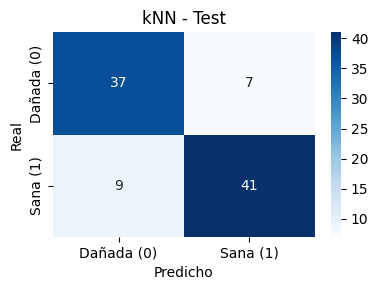


Entrenando MLP (CV=3)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores params: {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (128,)}
[VAL] acc=0.830 f1=0.840 prec=0.840 rec=0.840 auc=0.873


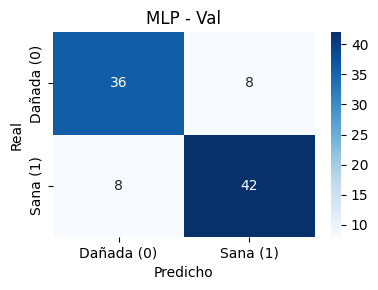

[TEST] acc=0.851 f1=0.857 prec=0.875 rec=0.840 auc=0.944


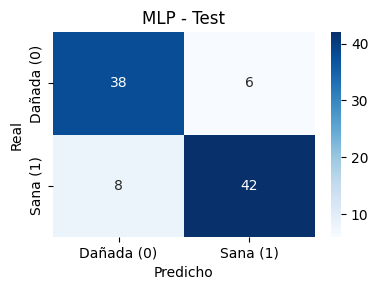

,model,best_params,pca_used,pca_components,pca_var_explained,train_time_sec,val_acc,val_prec,val_rec,val_f1,val_auc,test_acc,test_prec,test_rec,test_f1,test_auc
0,SVM_RBF,"{'clf__C': 3.0, 'clf__gamma': 'scale'}",True,200,0.837071,32.17,0.8617,0.8776,0.86,0.8687,0.9091,0.8936,0.9348,0.86,0.8958,0.9432
1,LogReg,"{'clf__C': 0.05, 'clf__penalty': 'l2'}",True,200,0.837071,4.82,0.7766,0.7843,0.80,0.7921,0.8341,0.8511,0.8462,0.88,0.8627,0.8982
2,RF,"{'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}",True,200,0.837071,11.69,0.7872,0.8261,0.76,0.7917,0.8734,0.9043,0.9184,0.90,0.9091,0.9350
3,kNN,"{'clf__n_neighbors': 3, 'clf__weights': 'uniform'}",True,200,0.837071,4.72,0.8191,0.8367,0.82,0.8283,0.8793,0.8298,0.8542,0.82,0.8367,0.9277
4,MLP,"{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (128,)}",True,200,0.837071,4.66,0.8298,0.8400,0.84,0.8400,0.8727,0.8511,0.8750,0.84,0.8571,0.9441


In [14]:
"""ENTRENAMIENTO Y EVALUACION DE MODELOS"""
results = []
best_models = {}

skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

for name, cfg in models.items():
    print("\n" + "="*80)
    print(f"Entrenando {name} (CV={CV_SPLITS})")
    gs = GridSearchCV(
        estimator=cfg["estimator"],
        param_grid=cfg["param_grid"],
        scoring="f1",   # equilibrio para la clase 1 (sana)
        cv=skf,
        n_jobs=N_JOBS,
        verbose=1
    )
    t0 = time.perf_counter()
    gs.fit(Xtr, ytr)
    t_train = time.perf_counter() - t0

    print("Mejores params:", gs.best_params_)
    best = gs.best_estimator_

    # Varianza explicada de PCA si aplica
    pca_var = np.nan
    if USE_PCA and "pca" in best.named_steps:
        pca_var = best.named_steps["pca"].explained_variance_ratio_.sum()

    # Validación
    yv_pred = best.predict(Xva)
    yv_prob = predict_proba_safe(best, Xva)
    va_acc, va_prec, va_rec, va_f1, va_auc, va_cm = compute_metrics(yva, yv_pred, yv_prob)
    print(f"[VAL] acc={va_acc:.3f} f1={va_f1:.3f} prec={va_prec:.3f} rec={va_rec:.3f} auc={va_auc:.3f}")
    show_confusion(va_cm, title=f"{name} - Val")

    # Refit en train+val y test
    best.fit(Xtrva, ytrva)
    yt_pred = best.predict(Xte)
    yt_prob = predict_proba_safe(best, Xte)
    te_acc, te_prec, te_rec, te_f1, te_auc, te_cm = compute_metrics(yte, yt_pred, yt_prob)
    print(f"[TEST] acc={te_acc:.3f} f1={te_f1:.3f} prec={te_prec:.3f} rec={te_rec:.3f} auc={te_auc:.3f}")
    show_confusion(te_cm, title=f"{name} - Test")

    results.append({
        "model": name,
        "best_params": gs.best_params_,
        "pca_used": USE_PCA,
        "pca_components": (best.named_steps["pca"].n_components if (USE_PCA and "pca" in best.named_steps) else 0),
        "pca_var_explained": float(pca_var) if pca_var==pca_var else np.nan,
        "train_time_sec": round(t_train, 2),
        "val_acc": round(va_acc, 4),
        "val_prec": round(va_prec, 4),
        "val_rec": round(va_rec, 4),
        "val_f1": round(va_f1, 4),
        "val_auc": round(va_auc, 4) if va_auc==va_auc else np.nan,
        "test_acc": round(te_acc, 4),
        "test_prec": round(te_prec, 4),
        "test_rec": round(te_rec, 4),
        "test_f1": round(te_f1, 4),
        "test_auc": round(te_auc, 4) if te_auc==te_auc else np.nan,
    })
    best_models[name] = best

pd.DataFrame(results)


In [15]:
# Mostrar resultados finales del mejor modelo
res_df = pd.DataFrame(results).sort_values(by=["val_f1","val_acc"], ascending=False)
display(res_df)

winner = res_df.iloc[0]["model"]
print(" ---------- Mejor modelo (por F1 val):", winner)


,model,best_params,pca_used,pca_components,pca_var_explained,train_time_sec,val_acc,val_prec,val_rec,val_f1,val_auc,test_acc,test_prec,test_rec,test_f1,test_auc
0,SVM_RBF,"{'clf__C': 3.0, 'clf__gamma': 'scale'}",True,200,0.837071,32.17,0.8617,0.8776,0.86,0.8687,0.9091,0.8936,0.9348,0.86,0.8958,0.9432
4,MLP,"{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (128,)}",True,200,0.837071,4.66,0.8298,0.8400,0.84,0.8400,0.8727,0.8511,0.8750,0.84,0.8571,0.9441
3,kNN,"{'clf__n_neighbors': 3, 'clf__weights': 'uniform'}",True,200,0.837071,4.72,0.8191,0.8367,0.82,0.8283,0.8793,0.8298,0.8542,0.82,0.8367,0.9277
1,LogReg,"{'clf__C': 0.05, 'clf__penalty': 'l2'}",True,200,0.837071,4.82,0.7766,0.7843,0.80,0.7921,0.8341,0.8511,0.8462,0.88,0.8627,0.8982
2,RF,"{'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}",True,200,0.837071,11.69,0.7872,0.8261,0.76,0.7917,0.8734,0.9043,0.9184,0.90,0.9091,0.9350


 ---------- Mejor modelo (por F1 val): SVM_RBF


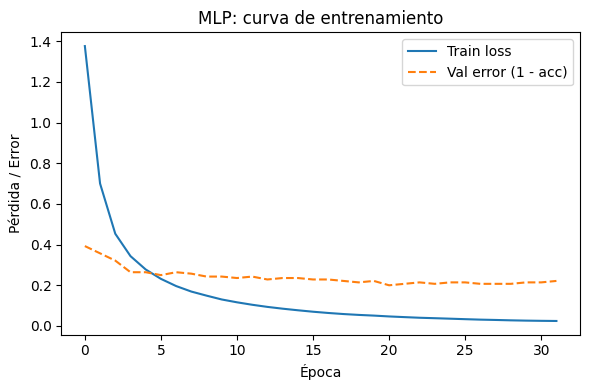

Épocas entrenadas: 32
Mejor val acc (interno): 0.8


In [16]:
# %% Curvas de entrenamiento del MLP (requiere que best_models["MLP"] exista de pasos previos)
import numpy as np
import matplotlib.pyplot as plt

assert "MLP" in best_models, "No encuentro el MLP en best_models. Asegúrate de haber corrido la celda de entrenamiento."

pipe_mlp = best_models["MLP"]
mlp = pipe_mlp.named_steps["clf"]

train_loss = getattr(mlp, "loss_curve_", None)
val_scores = getattr(mlp, "validation_scores_", None)  # accuracy por época (si early_stopping=True)

plt.figure(figsize=(6,4))
if train_loss is not None:
    plt.plot(train_loss, label="Train loss")
if val_scores is not None:
    plt.plot(1 - np.array(val_scores), label="Val error (1 - acc)", linestyle="--")
plt.xlabel("Época")
plt.ylabel("Pérdida / Error")
plt.title("MLP: curva de entrenamiento")
plt.legend()
plt.tight_layout()
plt.show()

# Info útil adicional
print(f"Épocas entrenadas: {getattr(mlp, 'n_iter_', 'NA')}")
print(f"Mejor val acc (interno): {np.max(val_scores) if val_scores is not None else 'NA'}")


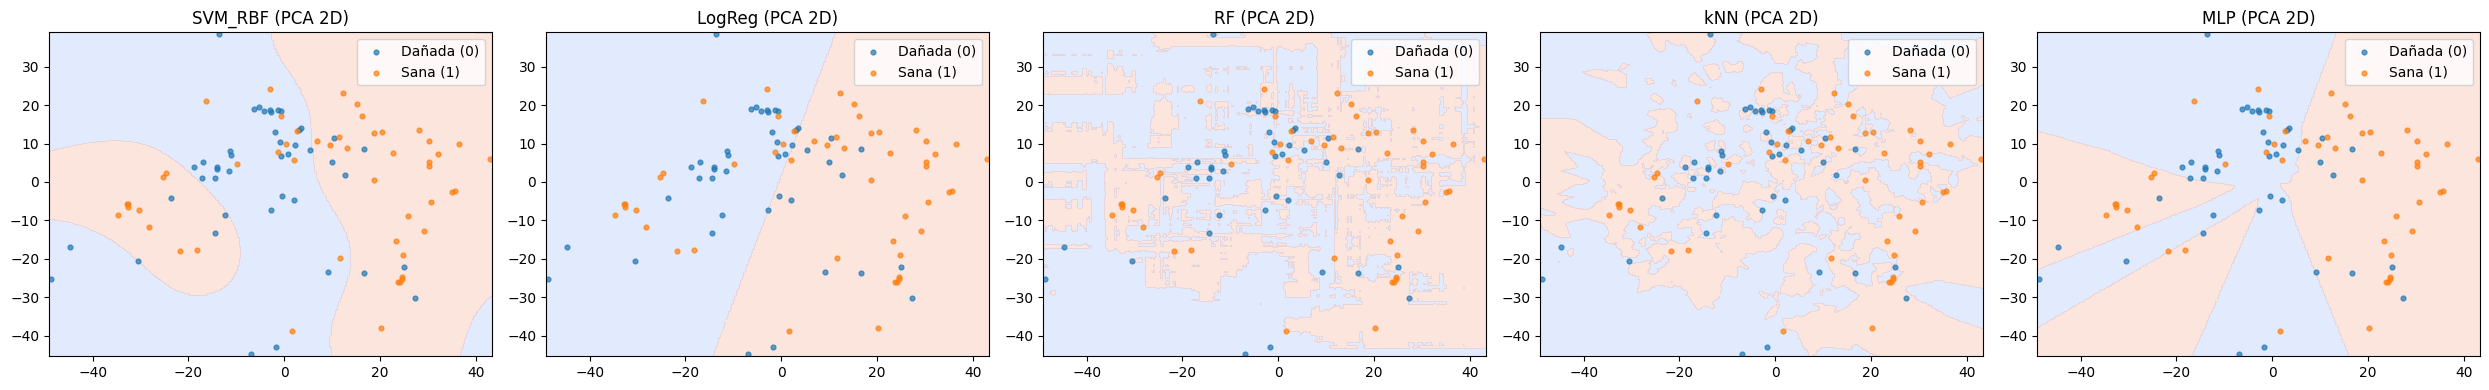

In [17]:
# %% Frontera de decisión 2D con PCA para todos los modelos
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Construimos la proyección 2D (fit en train+val)
scaler2d = StandardScaler().fit(Xtrva)
X2d_trva = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(scaler2d.transform(Xtrva))
X2d_te   = PCA(n_components=2, random_state=RANDOM_STATE).fit(scaler2d.transform(Xtrva)).transform(scaler2d.transform(Xte))
# Para consistencia, usemos un único PCA ajustado arriba:
pca2d = PCA(n_components=2, random_state=RANDOM_STATE).fit(scaler2d.transform(Xtrva))
X2d_trva = pca2d.transform(scaler2d.transform(Xtrva))
X2d_te   = pca2d.transform(scaler2d.transform(Xte))

def rebuild_clf_2d(name, best_pipe):
    """Crea un clasificador nuevo con los mismos hiperparámetros del 'clf' del pipeline."""
    clf = best_pipe.named_steps["clf"]
    params = clf.get_params()
    # clonado “tipo”:
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neural_network import MLPClassifier

    if name == "SVM_RBF":
        new_clf = SVC(**{k.replace("clf__", "") if k.startswith("clf__") else k: v for k,v in params.items()})
    elif name == "LogReg":
        new_clf = LogisticRegression(**{k.replace("clf__", "") if k.startswith("clf__") else k: v for k,v in params.items()})
    elif name == "RF":
        new_clf = RandomForestClassifier(**{k.replace("clf__", "") if k.startswith("clf__") else k: v for k,v in params.items()})
    elif name == "kNN":
        new_clf = KNeighborsClassifier(**{k.replace("clf__", "") if k.startswith("clf__") else k: v for k,v in params.items()})
    elif name == "MLP":
        # Para 2D, reducir hidden_layer_sizes si quieres curvas más suaves; mantenemos params
        new_clf = MLPClassifier(**{k.replace("clf__", "") if k.startswith("clf__") else k: v for k,v in params.items()})
    else:
        raise ValueError(f"Modelo no soportado para visualización: {name}")
    return new_clf

def plot_decision_boundary_2d(ax, clf, X2d, y, title):
    # mesh
    x_min, x_max = X2d[:,0].min()-0.5, X2d[:,0].max()+0.5
    y_min, y_max = X2d[:,1].min()-0.5, X2d[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                            np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    try:
        Z = clf.predict(grid)
    except Exception:
        # fallback si el modelo requiere probs
        Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5,0.5,1.5], cmap="coolwarm")
    # puntos
    ax.scatter(X2d[y==0,0], X2d[y==0,1], s=12, label="Dañada (0)", alpha=0.7)
    ax.scatter(X2d[y==1,0], X2d[y==1,1], s=12, label="Sana (1)", alpha=0.7)
    ax.set_title(title)
    ax.legend(loc="upper right")

# Entrenar y graficar cada modelo en 2D usando los hiperparámetros ganadores
fig, axes = plt.subplots(1, len(best_models), figsize=(5*len(best_models), 4))
if len(best_models) == 1:
    axes = [axes]

for ax, (name, pipe) in zip(axes, best_models.items()):
    clf2d = rebuild_clf_2d(name, pipe)
    clf2d.fit(X2d_trva, ytrva)
    plot_decision_boundary_2d(ax, clf2d, X2d_te, yte, f"{name} (PCA 2D)")

plt.tight_layout()
plt.show()


In [19]:

# Guardar modelos entrenados
import os, joblib
# rutas donde se guardarán los modelos entrenados
MOD_DIR = r"C:\Users\GMADRO04\Documents\PALAS_EOLICAS_ML\code_modelo"
SAVE_DIR = os.path.join(MOD_DIR)
os.makedirs(SAVE_DIR, exist_ok=True)

for name, pipe in best_models.items():
    path = os.path.join(SAVE_DIR, f"{name.lower()}_pipeline.joblib")
    joblib.dump(pipe, path)
    print(pyfiglet.figlet_format(f"Guardando {name}", font="digital"))
    print(f" Guardado: {path}")



+-+-+-+-+-+-+-+-+-+ +-+-+-+-+-+-+-+
|G|u|a|r|d|a|n|d|o| |S|V|M|_|R|B|F|
+-+-+-+-+-+-+-+-+-+ +-+-+-+-+-+-+-+

 Guardado: C:\Users\GMADRO04\Documents\PALAS_EOLICAS_ML\code_modelo\svm_rbf_pipeline.joblib
+-+-+-+-+-+-+-+-+-+ +-+-+-+-+-+-+
|G|u|a|r|d|a|n|d|o| |L|o|g|R|e|g|
+-+-+-+-+-+-+-+-+-+ +-+-+-+-+-+-+

 Guardado: C:\Users\GMADRO04\Documents\PALAS_EOLICAS_ML\code_modelo\logreg_pipeline.joblib
+-+-+-+-+-+-+-+-+-+ +-+-+
|G|u|a|r|d|a|n|d|o| |R|F|
+-+-+-+-+-+-+-+-+-+ +-+-+

 Guardado: C:\Users\GMADRO04\Documents\PALAS_EOLICAS_ML\code_modelo\rf_pipeline.joblib
+-+-+-+-+-+-+-+-+-+ +-+-+-+
|G|u|a|r|d|a|n|d|o| |k|N|N|
+-+-+-+-+-+-+-+-+-+ +-+-+-+

 Guardado: C:\Users\GMADRO04\Documents\PALAS_EOLICAS_ML\code_modelo\knn_pipeline.joblib
+-+-+-+-+-+-+-+-+-+ +-+-+-+
|G|u|a|r|d|a|n|d|o| |M|L|P|
+-+-+-+-+-+-+-+-+-+ +-+-+-+

 Guardado: C:\Users\GMADRO04\Documents\PALAS_EOLICAS_ML\code_modelo\mlp_pipeline.joblib
